## Preprocessing

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/cse151a_groupProject/isic-2024-challenge/train-image/temp_image'
output_folder_path = '/content/drive/MyDrive/cse151a_groupProject/isic-2024-challenge/processed-images'

os.makedirs(output_folder_path, exist_ok=True)


In [104]:
def morphological_closure(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
    closed_image = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel)

    return gray_image, closed_image

In [105]:
def identify_thin_long_structures(closed_image):
    blurred_image = cv2.GaussianBlur(closed_image, (5, 5), 0)
    edges = cv2.Canny(blurred_image, 50, 150)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    closed_edges = cv2.morphologyEx(dilated_edges, cv2.MORPH_CLOSE, kernel)

    binary_image = cv2.adaptiveThreshold(closed_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    aspect_ratio_threshold = 2.0
    area_threshold = 30
    thin_long_structures = np.zeros_like(binary_image)
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        aspect_ratio = max(w, h) / min(w, h)
        if aspect_ratio > aspect_ratio_threshold and area > area_threshold:
            thin_long_structures[labels == i] = 255

    return thin_long_structures


In [106]:
def bilinear_interpolation(image, mask):
    hair_coords = np.where(mask == 255)
    interpolated_image = image.copy()

    for y, x in zip(hair_coords[0], hair_coords[1]):
        surrounding_pixels = []
        for dy in [-1, 1]:
            for dx in [-1, 1]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < image.shape[0] and 0 <= nx < image.shape[1] and mask[ny, nx] == 0:
                    surrounding_pixels.append(image[ny, nx])

        if surrounding_pixels:
            interpolated_image[y, x] = np.mean(surrounding_pixels, axis=0)

    return interpolated_image

In [107]:
def process_image(image_path, output_folder_path):
    image = cv2.imread(image_path)

    gray_image, closed_image = morphological_closure(image)

    thin_long_structures = identify_thin_long_structures(closed_image)

    interpolated_image = bilinear_interpolation(image, thin_long_structures)

    file_name = os.path.basename(image_path)
    output_path = os.path.join(output_folder_path, file_name)

    cv2.imwrite(output_path, interpolated_image)

    plt.figure(figsize=(25, 5))
    plt.subplot(1, 5, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 5, 2)
    plt.title('Grayscale Image')
    plt.imshow(gray_image, cmap='gray')
    plt.subplot(1, 5, 3)
    plt.title('Morphological Closure')
    plt.imshow(closed_image, cmap='gray')
    plt.subplot(1, 5, 4)
    plt.title('Thin and Long Structures')
    plt.imshow(thin_long_structures, cmap='gray')
    plt.subplot(1, 5, 5)
    plt.title('Interpolated Image')
    plt.imshow(cv2.cvtColor(interpolated_image, cv2.COLOR_BGR2RGB))
    plt.show()


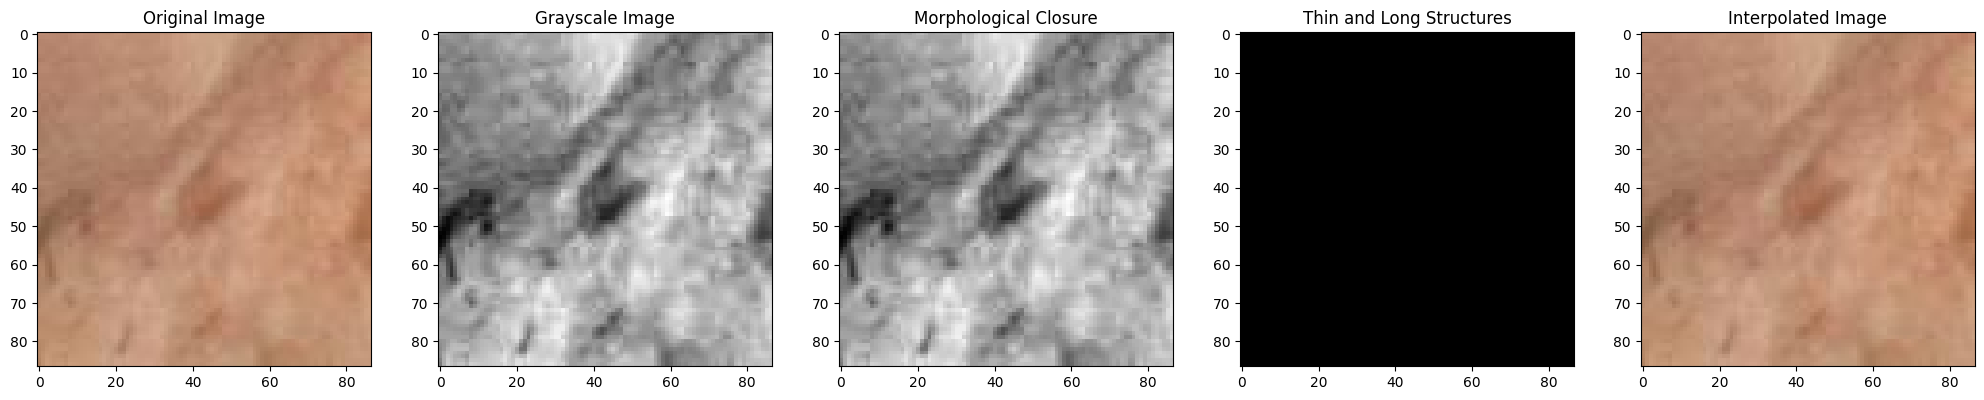

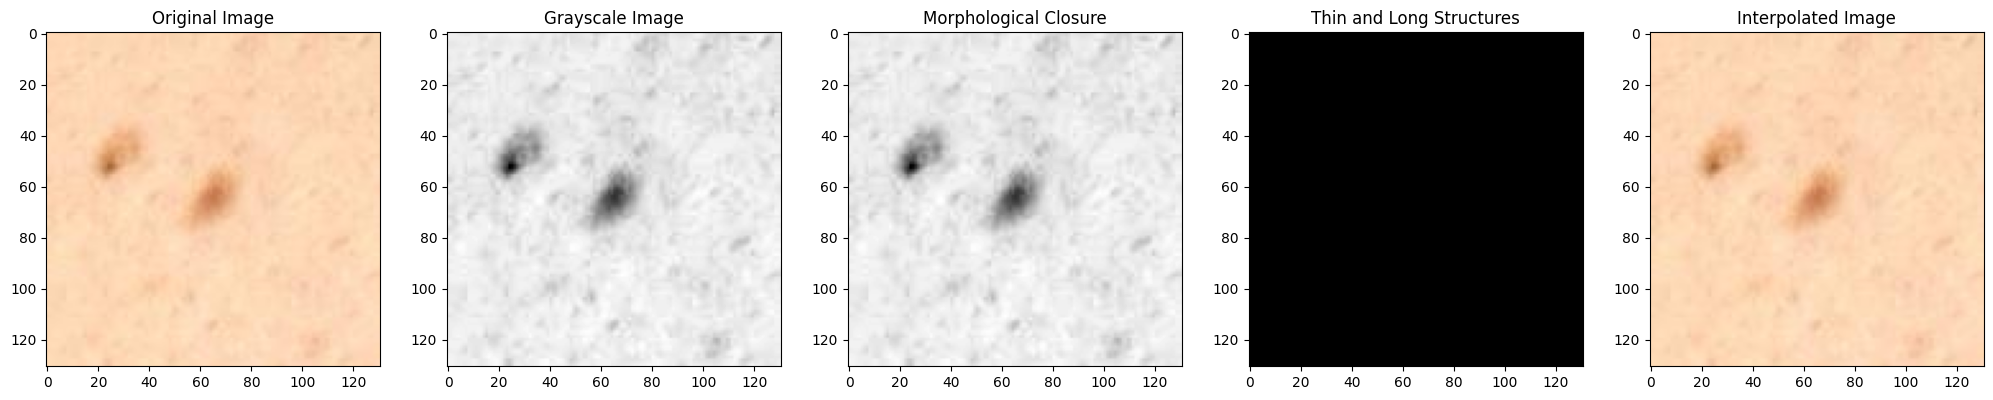

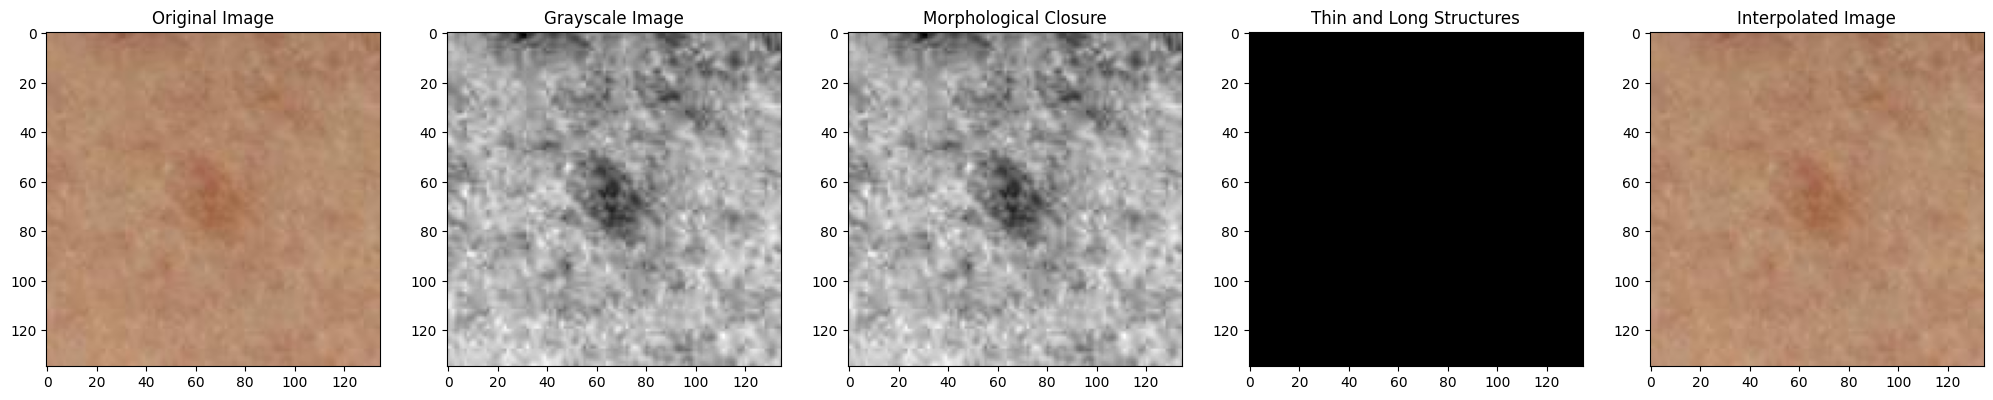

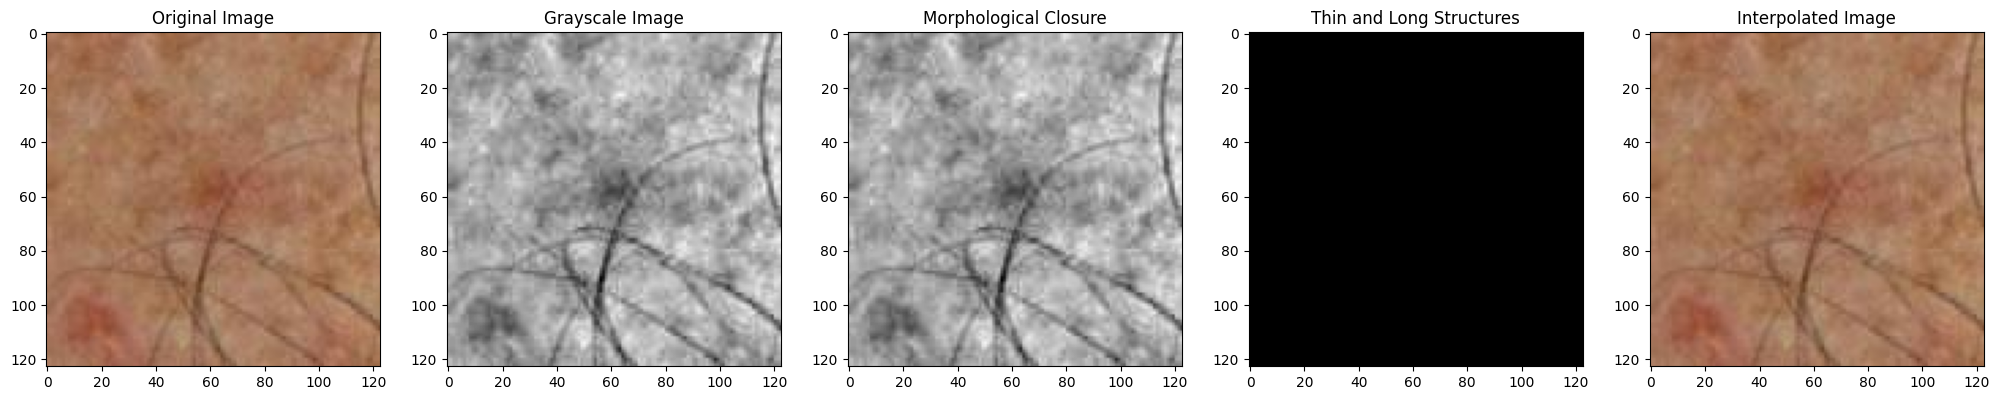

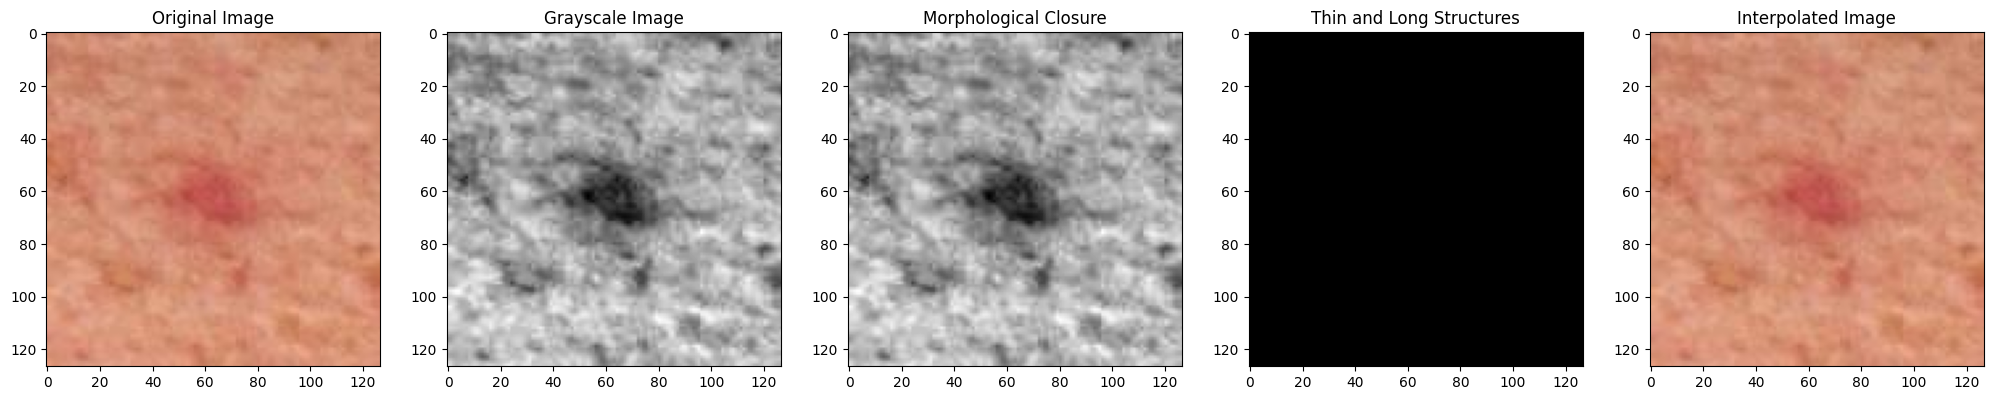

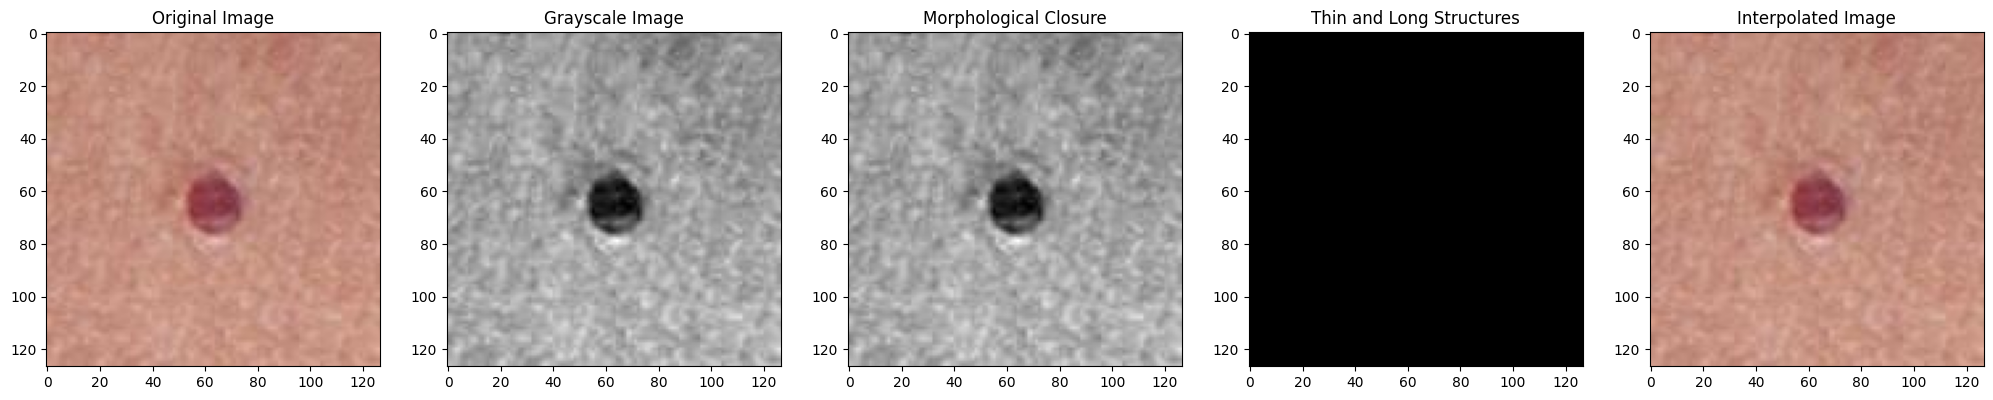

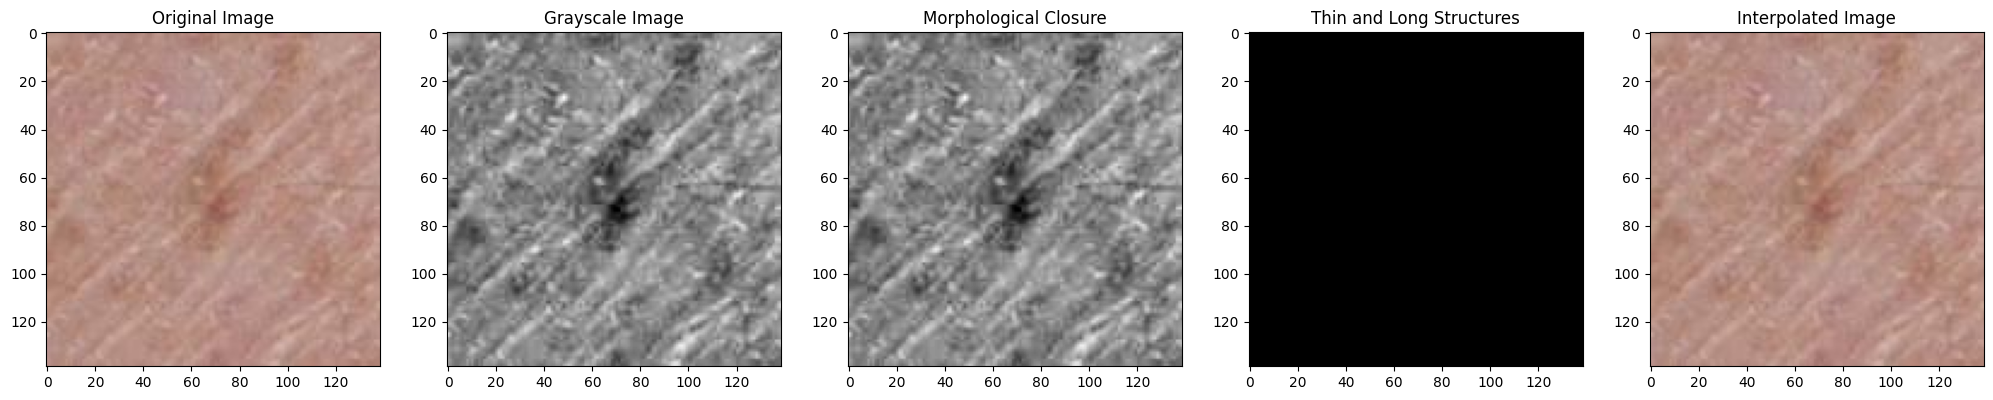

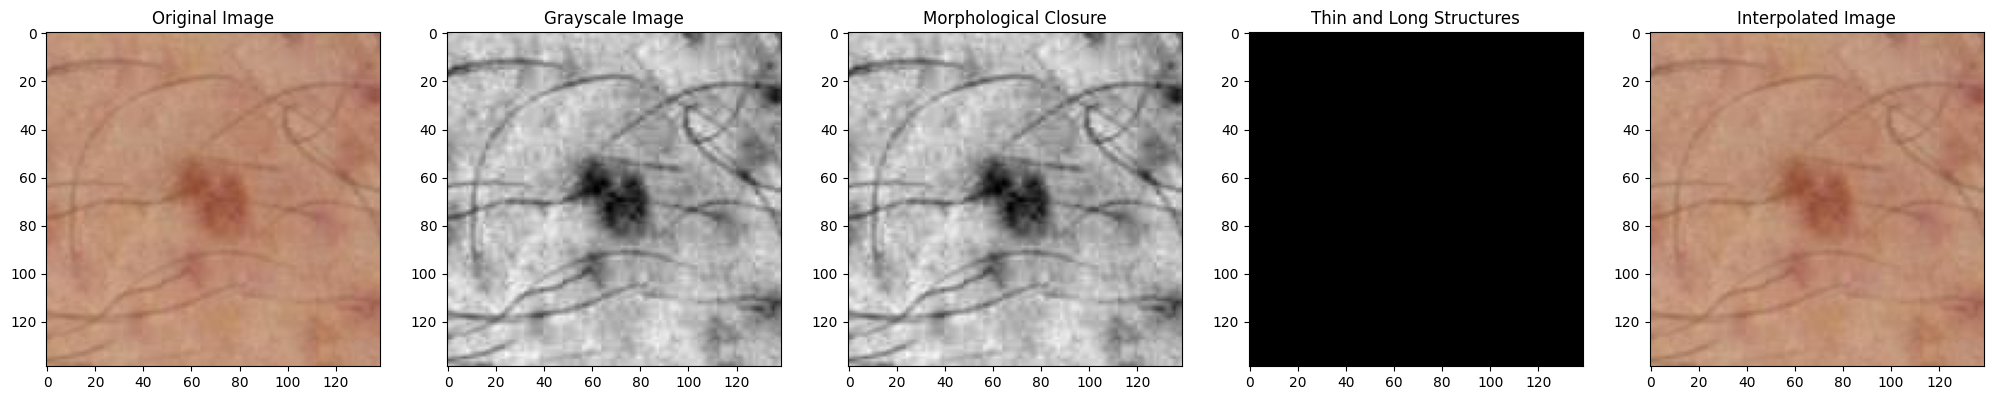

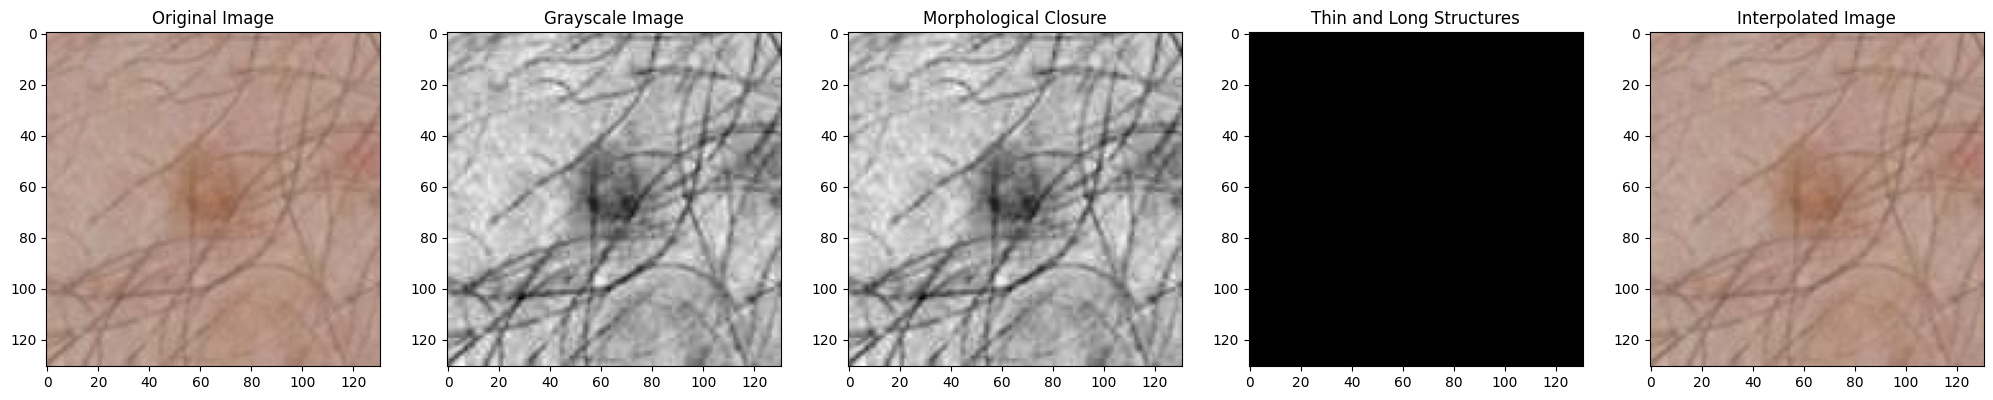

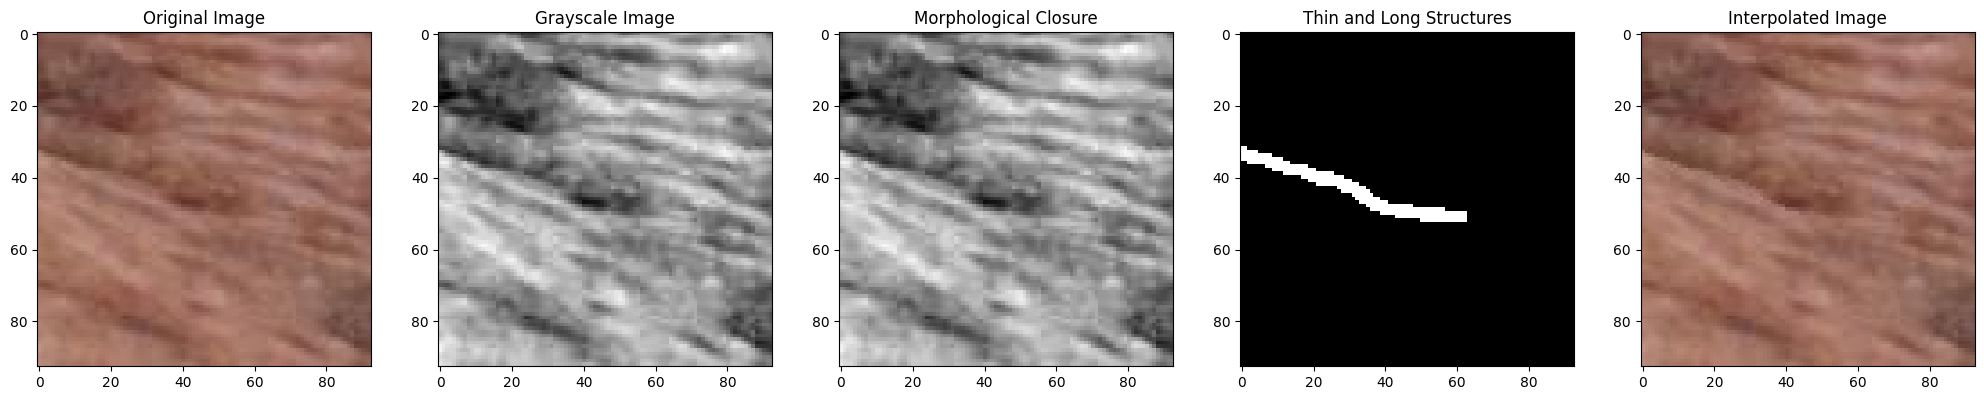

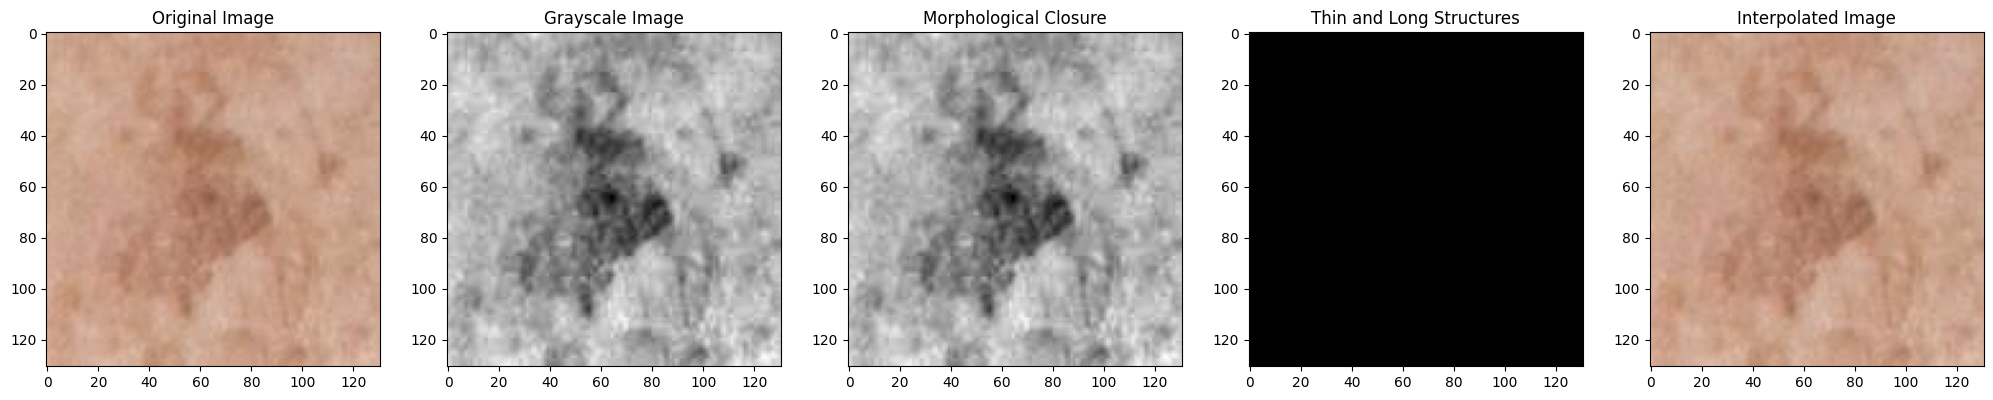

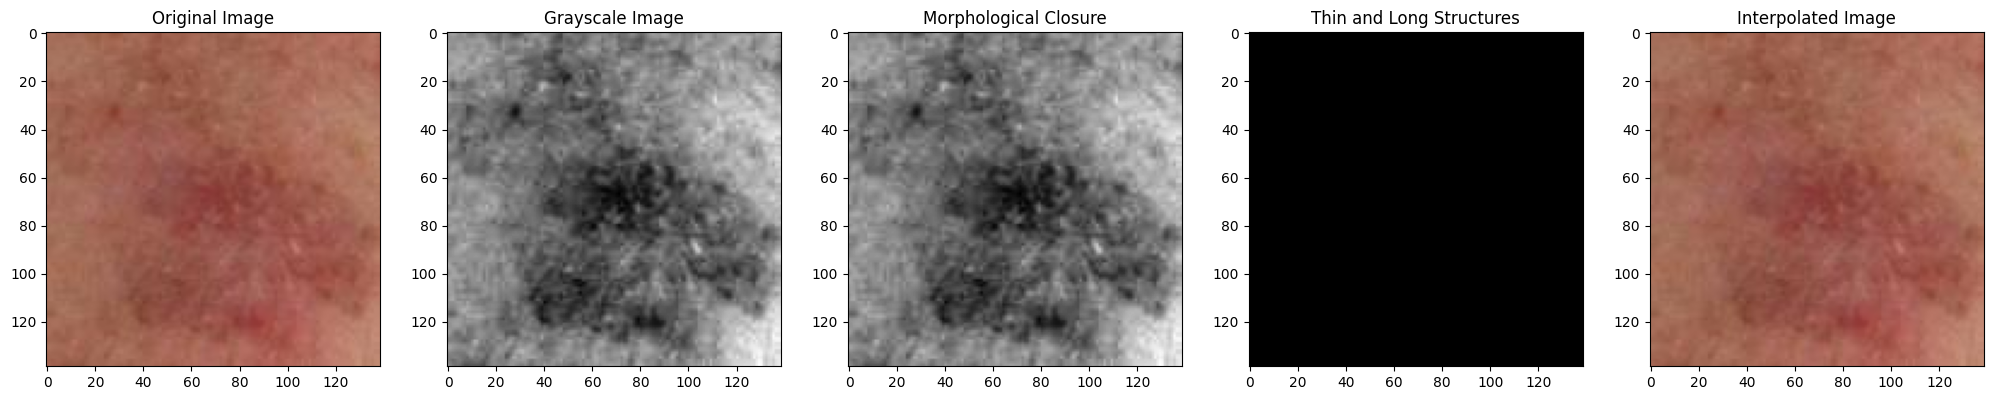

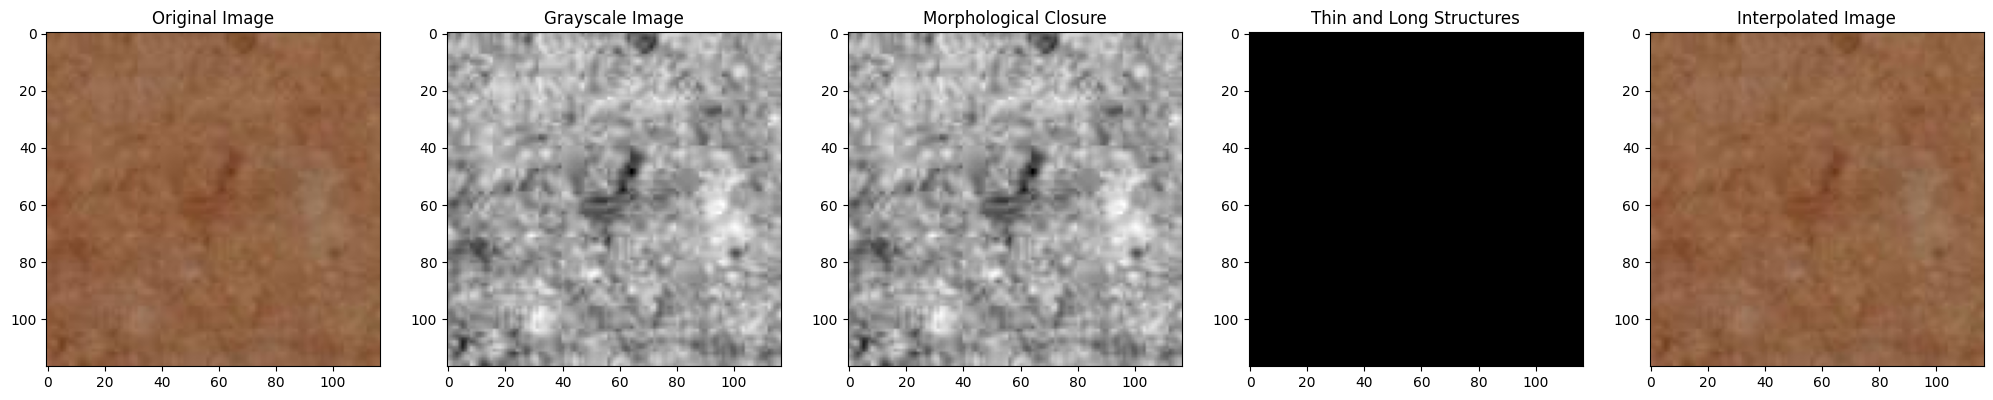

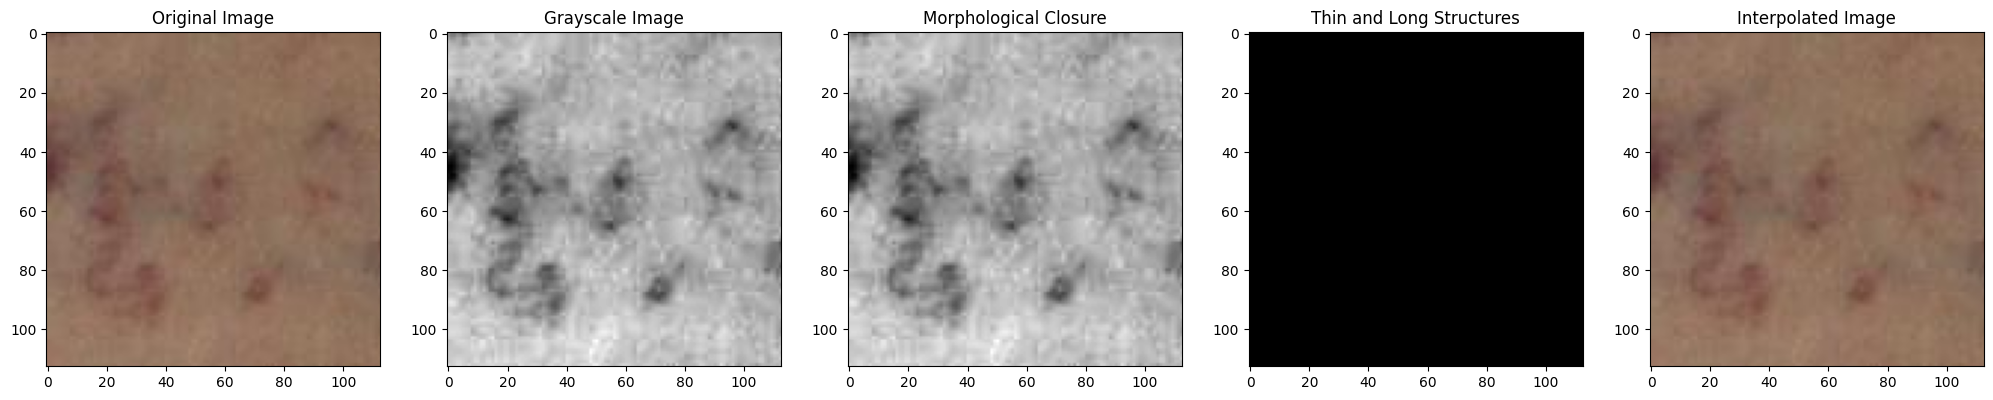

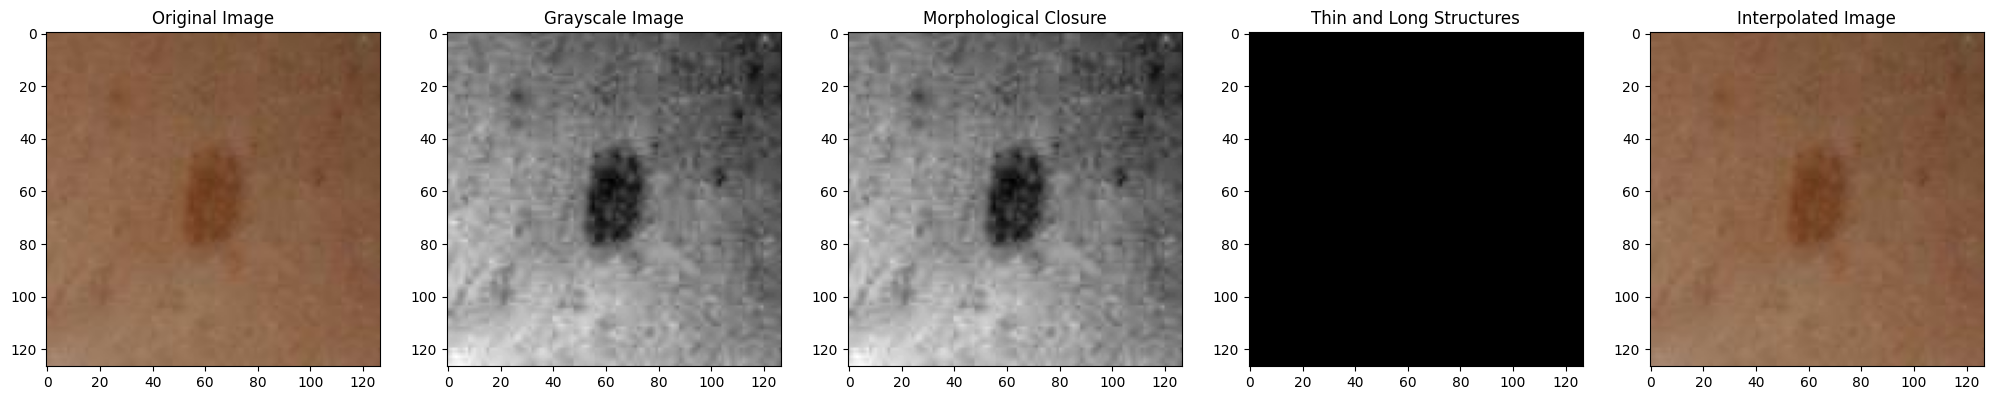

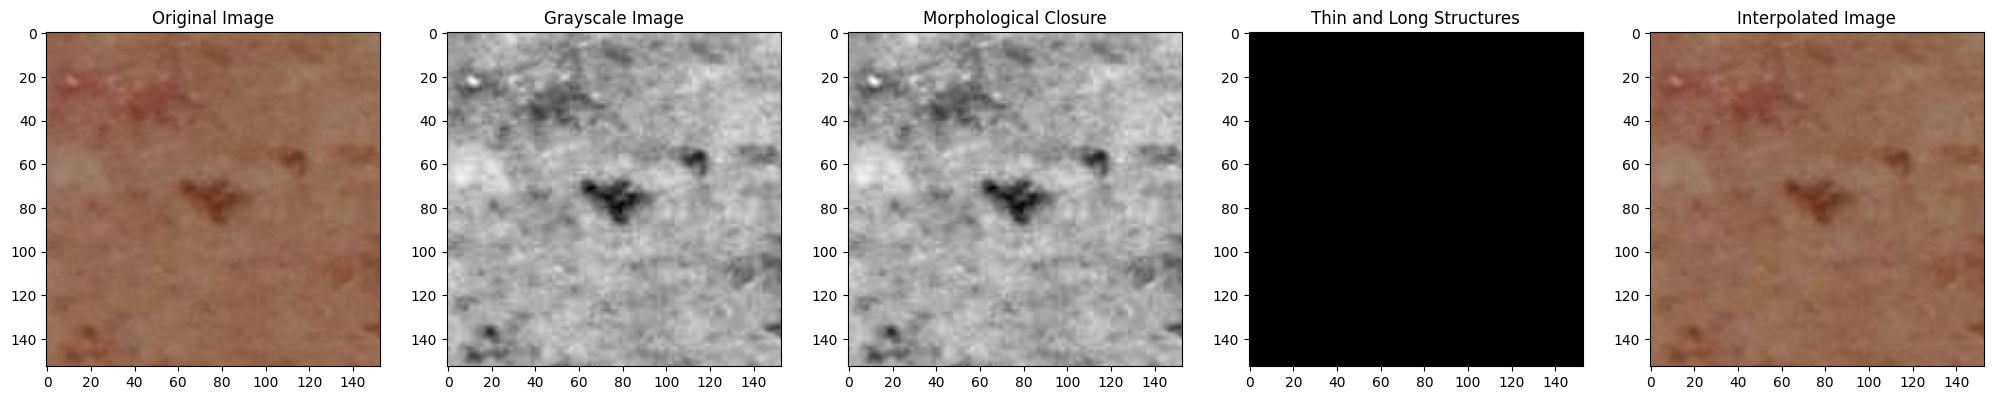

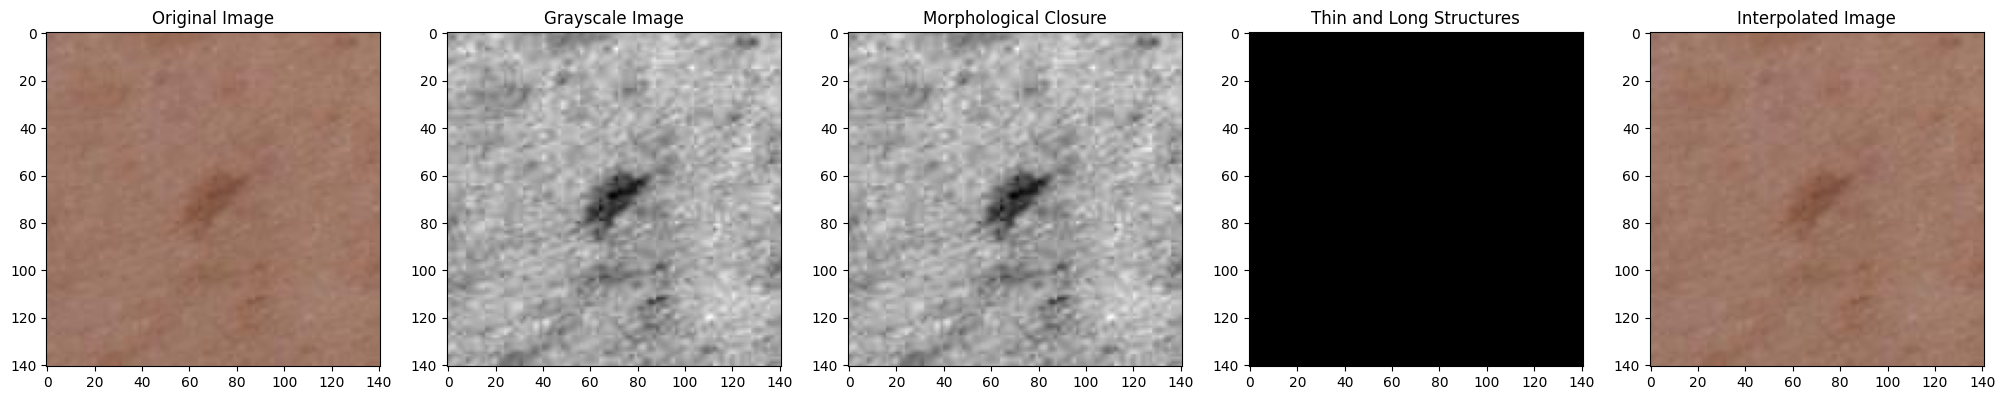

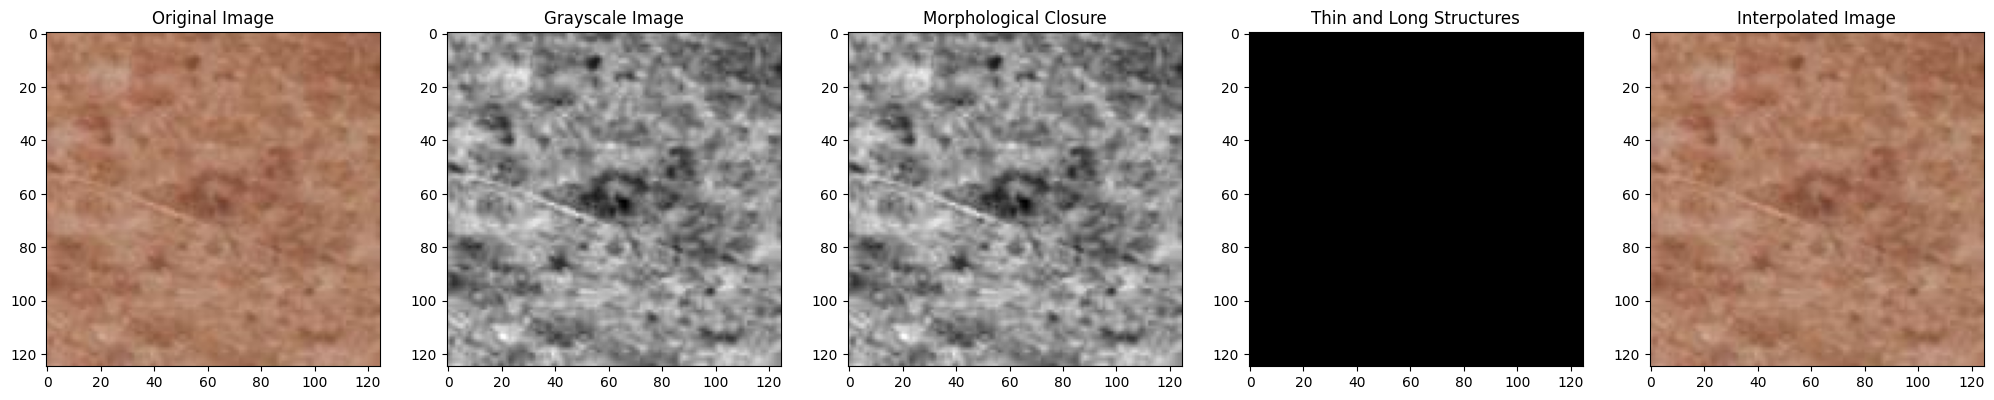

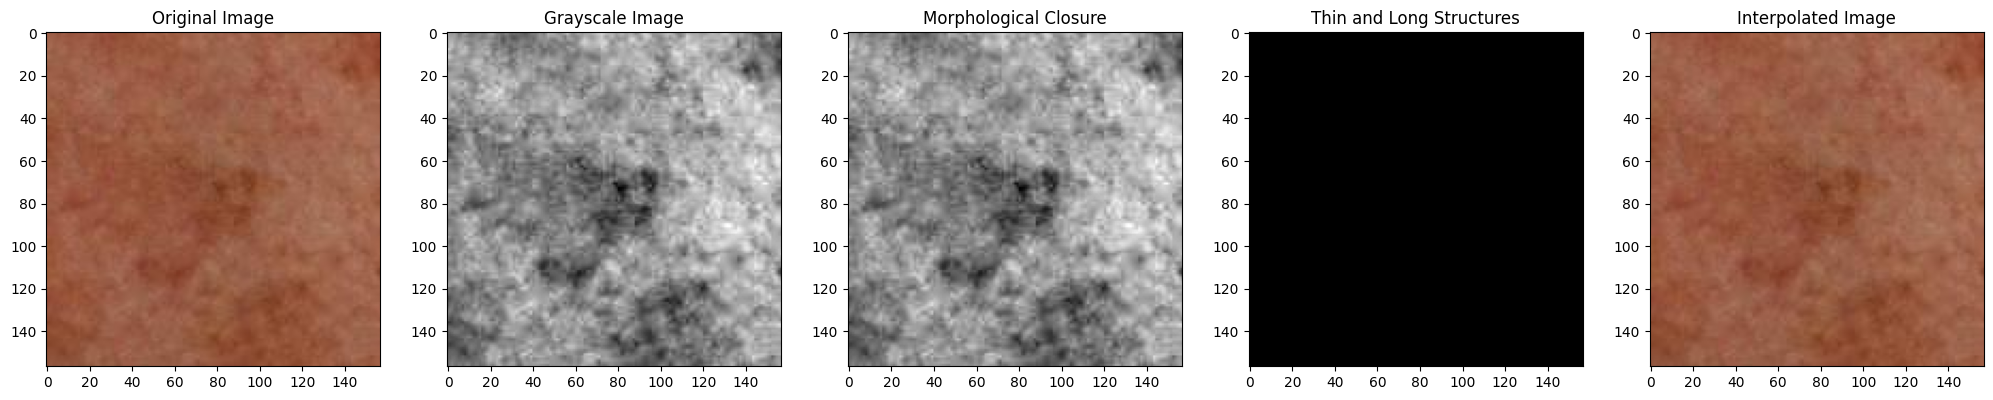

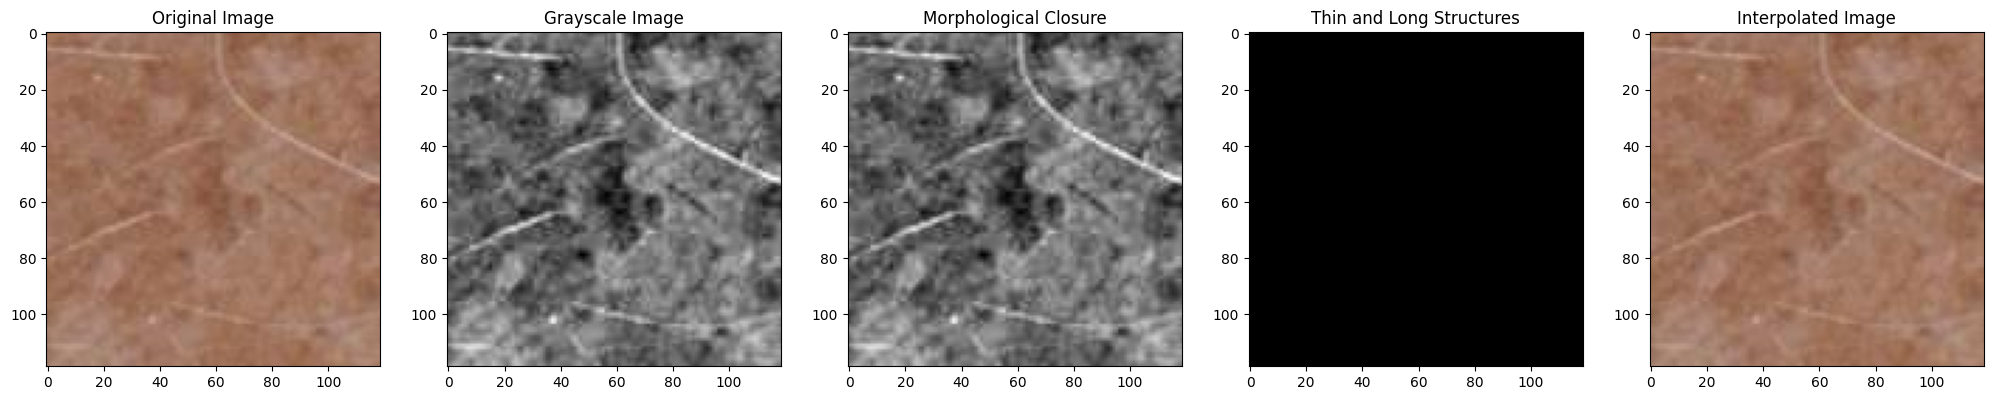

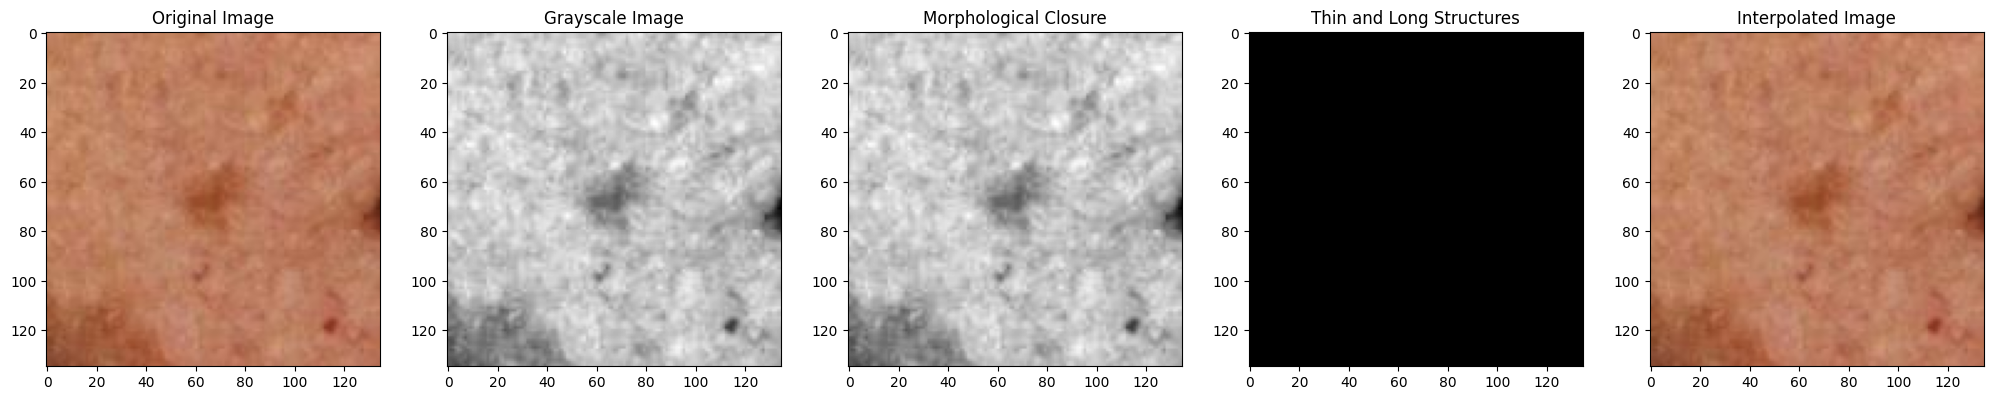

In [108]:
for file_name in os.listdir(folder_path):
    if file_name.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(folder_path, file_name)
        process_image(image_path, output_folder_path)


chatgpt usage: "what is grayscale morphological closure"
"how to make an image grayscale in python"
"how to identify hairs in an image"
"how to perform bilinear interpolation on images"